In [229]:
f_s = 10e6;
T_s = 1/f_s;

n_fft = 2^16;
n_ini = 0;
k = 49;

f_i = f_s/n_fft*k;
a_i = 1;
b_i = 0;

n_i = 1e-5;

t = 0:T_s:T_s*(n_fft+n_ini-1);
l =n_i*randn(size(t));
y = a_i*sin.(2*pi*f_i*t) + b_i + l;

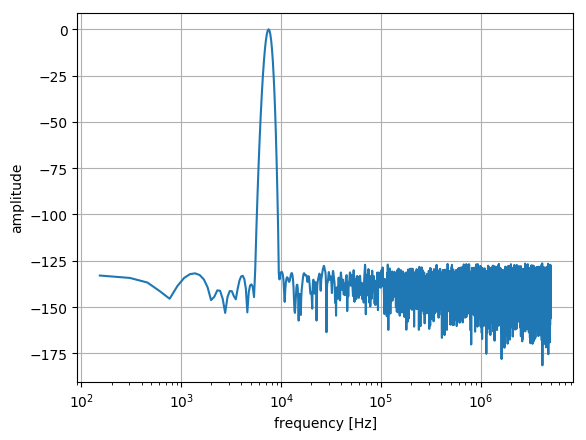

In [230]:
import DSP

w = DSP.Windows.kaiser(n_fft, 20);
wf = sum(w)/n_fft;
Y = fft(y.*w)/n_fft/wf;

f = linspace(0, f_s/2, (n_fft/2+1));

import PyPlot

PyPlot.semilogx(f, 20*log10.(2*abs.(Y[1:trunc(Int64, n_fft/2+1)])));
PyPlot.grid(true);
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude");

In [233]:
import DSP

function snr(y, f)
    n = length(y);
    
    xs = sin.(2*pi*f*(1:n));
    xc = cos.(2*pi*f*(1:n));
    a  = sum(2*xs.*y)/n;
    b  = sum(2*xc.*y)/n;

    i_sig = (a*xs+b*xc);
    i_noi = y - i_sig;
    
    w     = DSP.Windows.kaiser(n,20);
    wf    = sum(w.^2)/n;
    I_sig = fft(i_sig.*w)/n;
    I_noi = fft(i_noi.*w)/n;
    
    P_sig = sum(abs.(I_sig[1:end]).^2);
    P_noi = sum(abs.(I_noi[1:end]).^2);
    
    10*log10(P_sig/P_noi)
end

snr(y, f_i/f_s)

96.98002356800806